In [2]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, KernelPCA
import numpy as np

In [4]:
import numpy as np

class MyPCA:
    """
    A small class to perform PCA
    ------------
    Attributes:
    n_components: int, default is None
        number of principal components we want to project on
    eigvecs_: None
        All eigenvectors of covariance matrix decomposition, sorted w.r.t the maximum eigenvalues
    eigvals_: None
        All eigenvalues of covariance matrix decomposition, sorted w.r.t the maximum eigenvalues
    singular_values_: None
        The singular values corresponding to each of the selected components. The singular values are equal to the 2-norms of the n_components variables in the lower-dimensional space
    top_eigvecs: None
        The projection matrix
    """
    
    def __init__(self, n_components=None):
        """
        Constructor for PCA class.
        ----------
        Parameters:
        n_components : int (optional)
            The number of principal components we want to project on (default is None, meaning to project on all components).
        """
        self.n_components = n_components
        self.eigvecs_ = None
        self.eigvals_ = None
        self.singular_values_ = None
        self.top_eigvecs = None
    
    def fit_transform(self, X):
        """
        Fit the PCA model to data and transform the data.
        ----------
        Parameters:
        X : numpy array
            The data to fit the PCA model and transform, required in the form: (n x p) where n = number of observations and p = number of features
        ----------
        Returns:
        projected_data : numpy array
            The projected data.
        """
        # center the data in the feature space
        X_centered = X - np.mean(X, axis=0)

        # compute the covariance matrix
        cov_matrix = np.dot(X_centered.T, X_centered)/(X.shape[0])

        # perform eigen decomposition on the covariance matrix
        eigvals, eigvecs = np.linalg.eig(cov_matrix)

        # sort eigenvectors in decreasing order of eigenvalues
        idx = np.argsort(eigvals)[::-1]        
        eigvecs = eigvecs[:, idx]
        eigvals = eigvals[idx]
        
        self.eigvecs_ = eigvecs
        self.eigvals_ = eigvals

        self.singular_values_ = np.linalg.norm(np.dot(X, self.eigvecs_), axis = 0)

        self.top_eigvecs = self.eigvecs_

        # select the top n_components eigenvectors
        if self.n_components is not None:
            self.top_eigvecs = self.eigvecs_[:, :self.n_components]

        
        # project the original data onto the selected eigenvectors
        projected_data = np.dot(X, self.top_eigvecs)

        return projected_data

# EX 1

In [3]:
X = np.genfromtxt("../Datasets/data_kPCA_2022-2023.txt")
y = np.genfromtxt("../Datasets/labels_kPCA_2022-2023.txt")

In [9]:
mypca = MyPCA(2)
skpca = PCA(2)
X_projected = mypca.fit_transform(X)
X_projected_ = skpca.fit_transform(X)

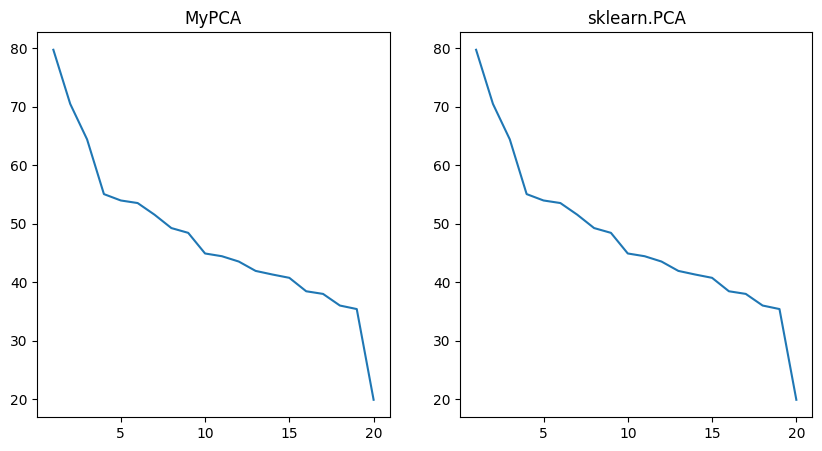

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.plot(np.arange(1, X.shape[1] + 1) ,mypca.singular_values_)
ax1.set_title('MyPCA')

ax2.plot(np.arange(1, X.shape[1] + 1) ,PCA().fit(X).singular_values_ )
ax2.set_title('sklearn.PCA')

plt.show()

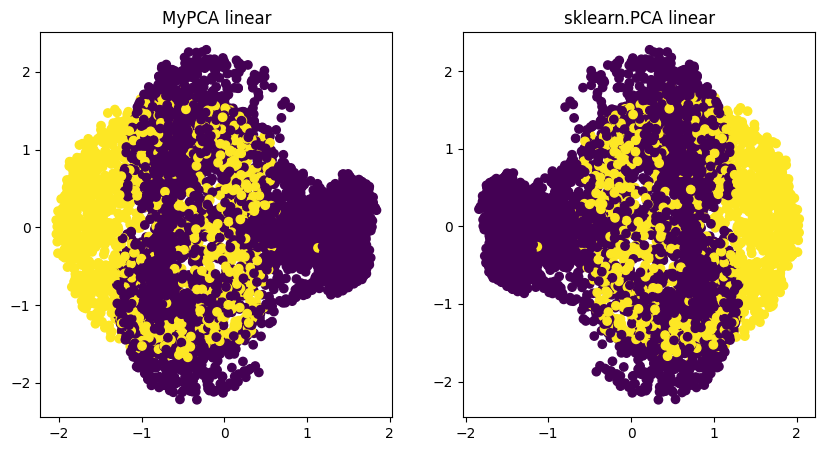

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.scatter(X_projected[:,0], X_projected[:,1], c = y)
ax1.set_title('MyPCA linear')

ax2.scatter(X_projected_[:,0], X_projected_[:,1], c = y)
ax2.set_title('sklearn.PCA linear')

plt.show()


In [ ]:
def rbf(x1, x2, sigma):
    return np.exp(-np.linalg.norm(x1-x2)/(2*sigma**2))

def my_rbfPCA(X, k, sigma):
    """
    X: dataframe
        dataframe with n observation and p features (nxp)
    k: int
        number of principal components we want to project on
    sigma: float
        width parameter of RBF kernel 
    output: array-shape
        return the projected data (nxk), where k is the number of principal components we have projected on
    """
    K = np.empty([X.shape[0], X.shape[0]])
    for i, j in range(X.shape[0]):
        K[i,j] = rbf(X[i,:], X[j,:], sigma=sigma)

    # center the data
    X_std = X - X.mean(axis=0)

    # compute the covariance matrix
    cov_mat = np.dot(X_std.T, X_std)

    eig_vals, eig_vecs = np.linalg.eig(cov_mat)
    
    sorted_indices = np.argsort(eig_vals)[::-1]
    sorted_eigvecs = eig_vecs[:,sorted_indices]
    
    top_k_eigvecs = sorted_eigvecs[:,:k]

    projection_matrix = top_k_eigvecs

    return np.dot(X, projection_matrix)

In [14]:
import numpy as np

def my_rbfPCA(X, k, gamma):
    """
    X: numpy array
        array with n observation and p features (nxp)
    k: int
        number of principal components we want to project on
    sigma: float
        width parameter of the RBF kernel
    output: numpy array
        return the projected data (nxk), where k is the number of principal components we have projected on
    """
    # center the data in the feature space
    X_centered = X - np.mean(X, axis=0)

    # compute the squared Euclidean distances
    D = np.sum(X_centered**2, axis=1).reshape(-1, 1) + np.sum(X_centered**2, axis=1) - 2*np.dot(X_centered, X_centered.T)
    
    # compute the RBF kernel matrix
    K = np.exp(-gamma*D)
    
    # double center the kernel matrix
    n = K.shape[0]
    one_n = np.ones((n, n)) / n
    K_centered = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)
    
    # perform eigen decomposition on the centered kernel matrix
    _, eigvecs = np.linalg.eigh(K_centered)
    
    # select the top k eigenvectors and project the original data
    top_k_eigvecs = eigvecs[:, -k:]
    projected_data = np.dot(K_centered, top_k_eigvecs)

    return projected_data


In [15]:
X_projected = my_rbfPCA(X, 2, gamma = 0.5)
X_projected_ = KernelPCA(n_components=2, kernel='rbf', gamma=0.5).fit_transform(X)


KeyboardInterrupt: 

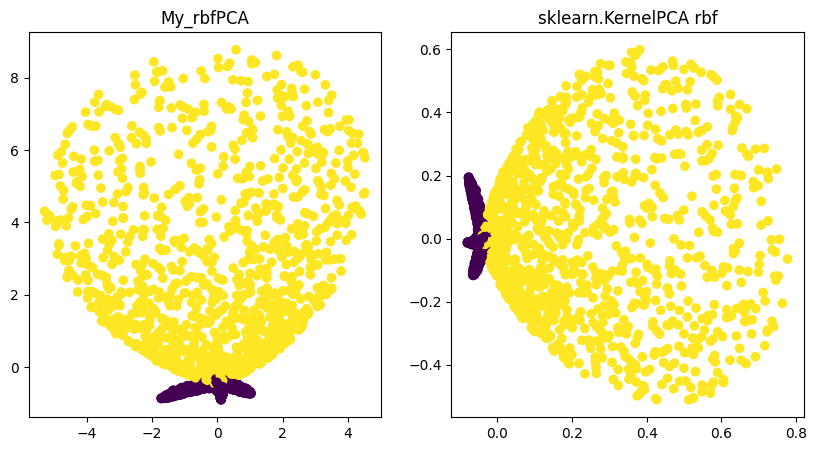

In [35]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.scatter(X_projected[:,0], X_projected[:,1], c = y)
ax1.set_title('My_rbfPCA')

ax2.scatter(X_projected_[:,0], X_projected_[:,1], c = y)
ax2.set_title('sklearn.KernelPCA rbf')

plt.show()